<a href="https://colab.research.google.com/github/anastasiapodoliakina/coursework/blob/main/figureskating_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import f1_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import xgboost as xgb
import shap
from xgboost import XGBRegressor
import statsmodels.api as sm
from scipy import stats
from statsmodels.stats.multitest import multipletests
from itertools import combinations


In [39]:
file_path1 = "/content/drive/MyDrive/figure_skating/skaters.xlsx"
file_path2 = "/content/drive/MyDrive/figure_skating/executed_elements.xlsx"
file_path3 = "/content/drive/MyDrive/figure_skating/program_components.xlsx"

skaters = pd.read_excel(file_path1)
elements = pd.read_excel(file_path2)
components = pd.read_excel(file_path3)

In [40]:
df = skaters.drop_duplicates()
df = skaters.drop(columns=['skater_id', 'skater_name_1', 'skater_name_2'])

df['noc'] = df['noc'].astype('category')
df['category'] = df['category'].astype('category')
df['segment'] = df['segment'].astype('category')

X = df[['total_element_score', 'total_segment_score', 'starting_number', 'noc', 'category']]
y = df['total_program_component_score']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [41]:
lin_reg = LinearRegression()
lin_reg.fit(X_train[['total_element_score', 'total_segment_score', 'starting_number']], y_train)
y_pred_lin = lin_reg.predict(X_test[['total_element_score', 'total_segment_score', 'starting_number']])

lasso = Lasso(alpha=0.1)
lasso.fit(X_train[['total_element_score', 'total_segment_score', 'starting_number']], y_train)
y_pred_lasso = lasso.predict(X_test[['total_element_score', 'total_segment_score', 'starting_number']])

xgb_model = xgb.XGBRegressor(objective='reg:squarederror')
xgb_model.fit(X_train[['total_element_score', 'total_segment_score', 'starting_number']], y_train)
y_pred_xgb = xgb_model.predict(X_test[['total_element_score', 'total_segment_score', 'starting_number']])

print("Linear Regression:")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_lin))}")
print(f"MAE: {mean_absolute_error(y_test, y_pred_lin)}")

print("\nLasso Regression:")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_lasso))}")
print(f"MAE: {mean_absolute_error(y_test, y_pred_lasso)}")

print("\nXGBoost:")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_xgb))}")
print(f"MAE: {mean_absolute_error(y_test, y_pred_xgb)}")

Linear Regression:
RMSE: 0.7124261027603334
MAE: 0.43986521944846024

Lasso Regression:
RMSE: 0.718853905351269
MAE: 0.45264556181952453

XGBoost:
RMSE: 3.0214635513534343
MAE: 1.96763548559072


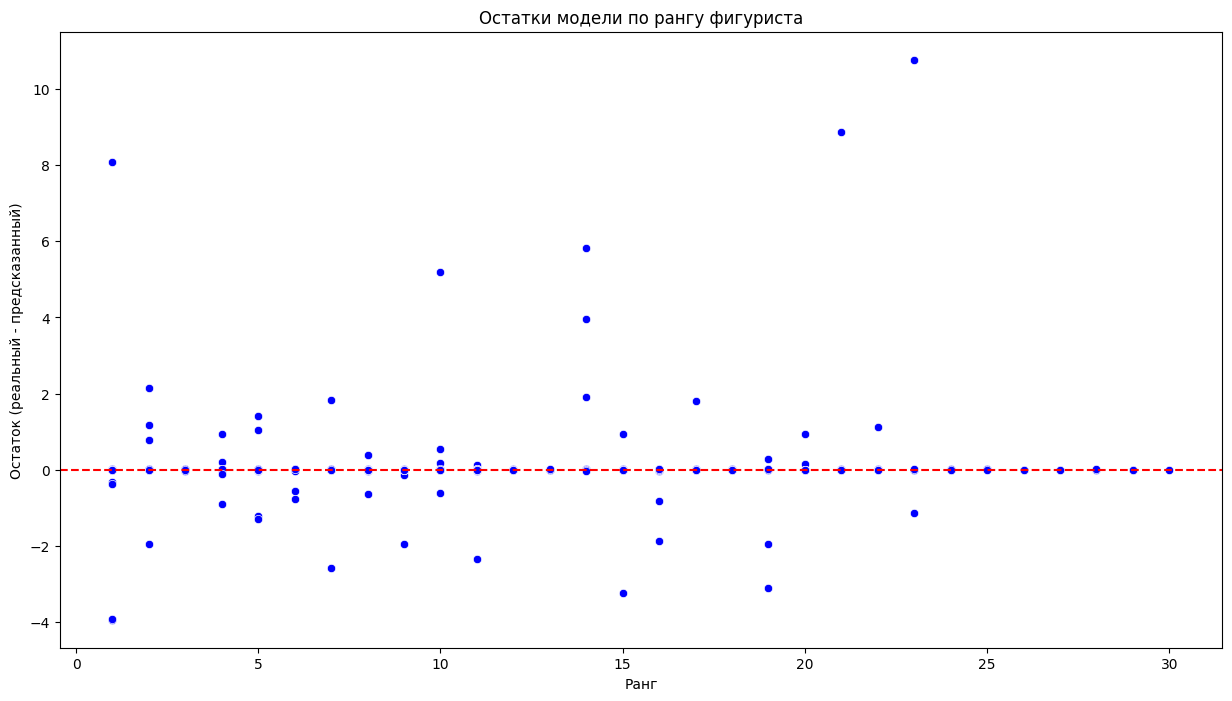

In [42]:
df['predicted_component'] = xgb_model.predict(X[['total_element_score', 'total_segment_score', 'starting_number']])
df['residual'] = df['total_program_component_score'] - df['predicted_component']

plt.figure(figsize=(15, 8))
sns.scatterplot(x='rank', y='residual', data=df, color='blue')
plt.axhline(0, color='red', linestyle='--')
plt.title('Остатки модели по рангу фигуриста')
plt.xlabel('Ранг')
plt.ylabel('Остаток (реальный - предсказанный)')
plt.show()



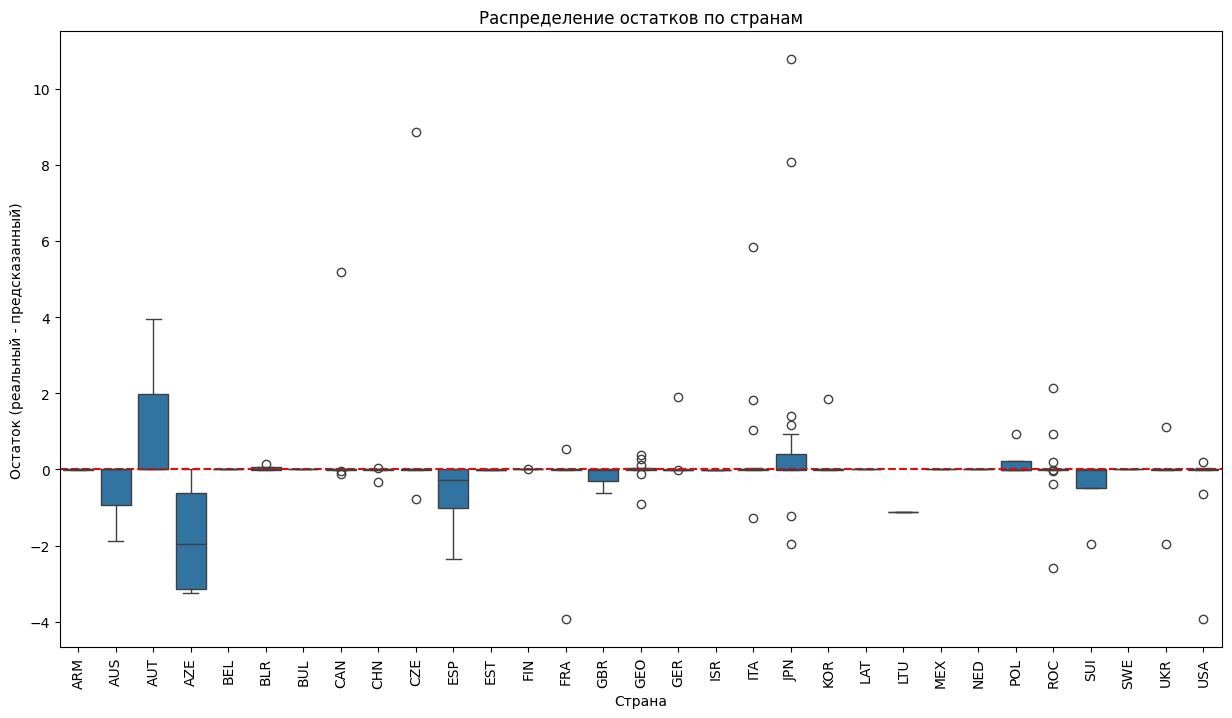

In [43]:
plt.figure(figsize=(15, 8))
sns.boxplot(x='noc', y='residual', data=df)
plt.xticks(rotation=90)
plt.axhline(0, color='red', linestyle='--')
plt.title('Распределение остатков по странам')
plt.xlabel('Страна')
plt.ylabel('Остаток (реальный - предсказанный)')
plt.show()

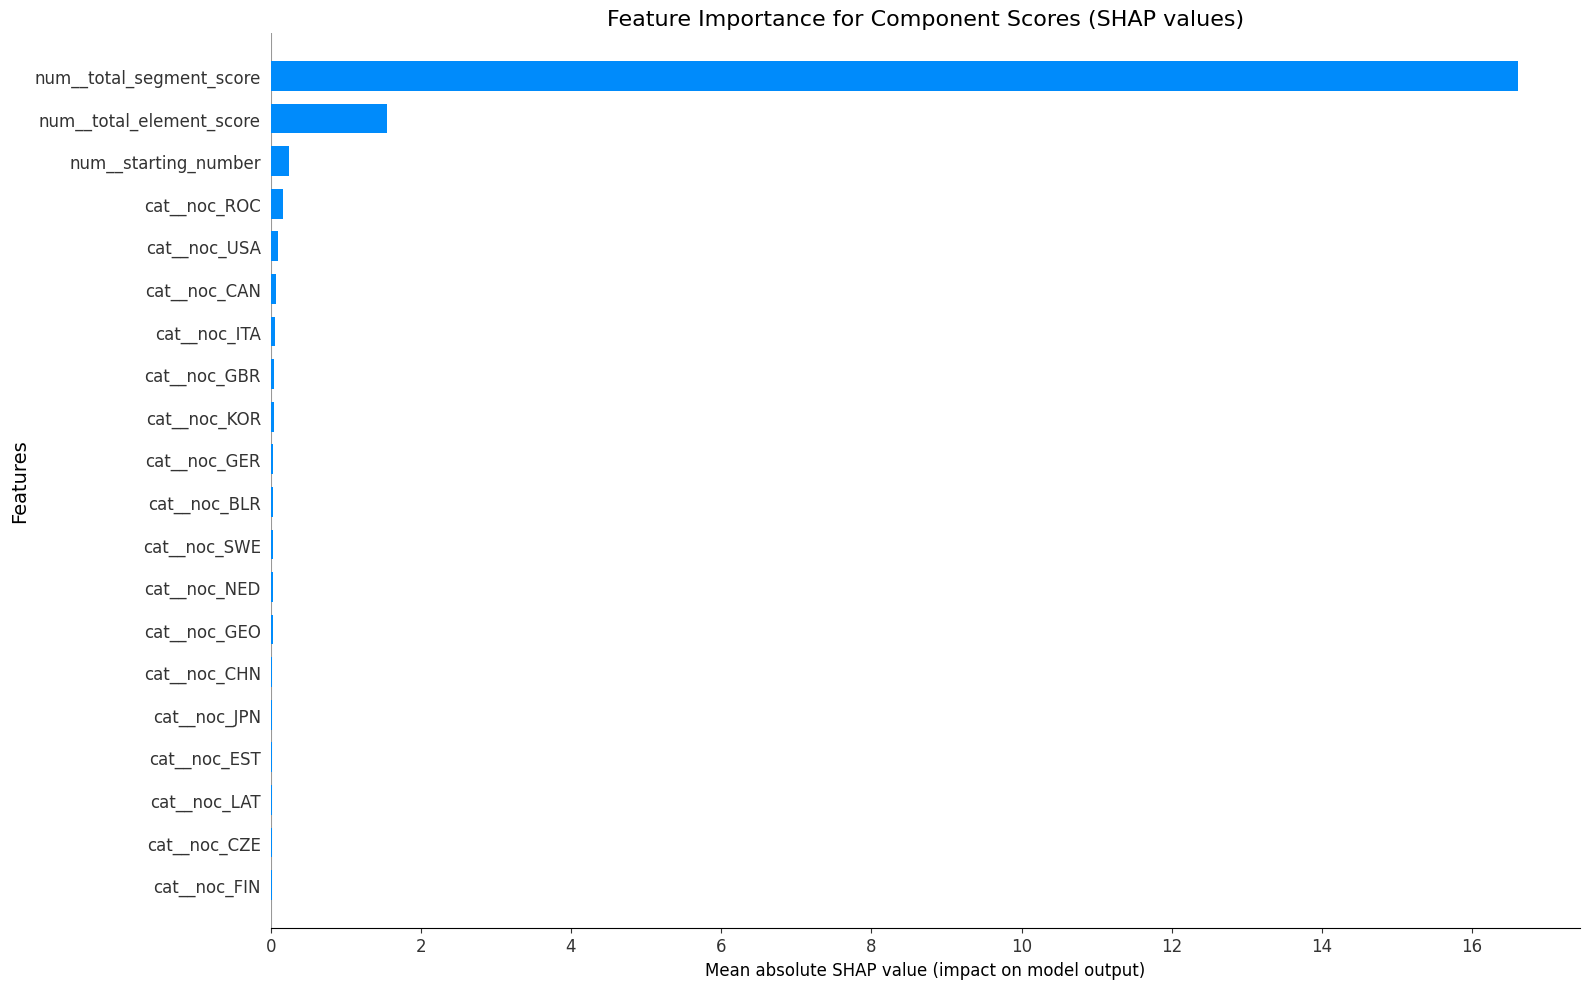

In [44]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', ['total_element_score', 'total_segment_score', 'starting_number']),
        ('cat', OneHotEncoder(handle_unknown='ignore'), ['noc'])
    ])

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', xgb.XGBRegressor(objective='reg:squarederror'))
])

pipeline.fit(X_train, y_train)
y_pred_country = pipeline.predict(X_test)

explainer = shap.Explainer(pipeline.named_steps['regressor'])
shap_values = explainer(pipeline.named_steps['preprocessor'].transform(X_train))

feature_names = pipeline.named_steps['preprocessor'].get_feature_names_out()

plt.figure(figsize=(16, 10))

shap.summary_plot(shap_values,
                 pipeline.named_steps['preprocessor'].transform(X_train),
                 feature_names=feature_names,
                 plot_type='bar',
                 show=False,
                 plot_size=(16, 10))

plt.title("Feature Importance for Component Scores (SHAP values)", fontsize=16)
plt.xlabel("Mean absolute SHAP value (impact on model output)", fontsize=12)
plt.ylabel("Features", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()

plt.show()

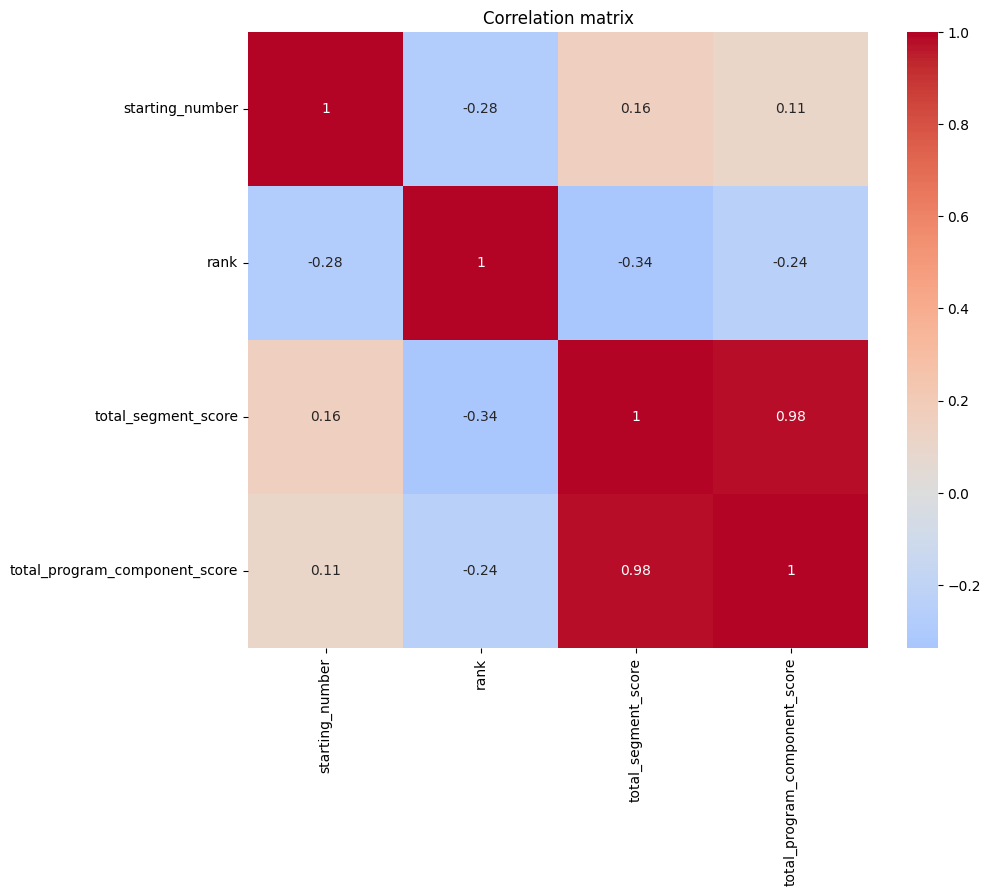

In [45]:
corr_matrix = df[['starting_number', 'rank', 'total_segment_score', 'total_program_component_score']].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation matrix')
plt.show()

In [46]:
elements_agg = elements.groupby('skater_id').agg({
    'base_value': ['sum', 'mean'],
    'goe': ['mean', 'max']
}).reset_index()
elements_agg.columns = ['skater_id', 'base_value_sum', 'base_value_mean', 'goe_mean', 'goe_max']

judge_cols = [f'judge_{i}' for i in range(1, 10)]
components_agg = components.groupby('skater_id')[judge_cols].mean().reset_index()
components_agg['judges_mean'] = components_agg[judge_cols].mean(axis=1)
components_agg['judges_std'] = components_agg[judge_cols].std(axis=1)

df = skaters.merge(elements_agg, on='skater_id', how='left')\
            .merge(components_agg, on='skater_id', how='left')

for col in df.select_dtypes(include=np.number).columns:
    df[col] = df[col].fillna(df[col].median())

tech_features = [
    'base_value_sum',
    'base_value_mean',
    'goe_mean',
    'goe_max',
    'judges_mean',
    'judges_std',
    'starting_number'
]
categorical_features = ['noc', 'category', 'segment']

X = df[tech_features + categorical_features]
y_tech = df['total_element_score']
y_comp = df['total_program_component_score']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), tech_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
])

models = {
    'Ridge': Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', Ridge(alpha=1.0))
    ]),
    'Lasso': Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', Lasso(alpha=0.01, max_iter=10000))
    ]),
    'XGBoost': Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', xgb.XGBRegressor(
            objective='reg:squarederror',
            n_estimators=50,
            max_depth=2,
            learning_rate=0.1,
            reg_alpha=0.5,
            reg_lambda=0.5,
            random_state=42))
    ])
}

def evaluate_model(model, X, y):
    cv = KFold(n_splits=5, shuffle=True, random_state=42)
    rmse = np.sqrt(-cross_val_score(model, X, y,
                                  cv=cv,
                                  scoring='neg_mean_squared_error',
                                  n_jobs=-1).mean())
    mae = -cross_val_score(model, X, y,
                          cv=cv,
                          scoring='neg_mean_absolute_error',
                          n_jobs=-1).mean()
    return rmse, mae

print("Evaluation for technical score (total_element_score):")
tech_results = {}
for name, model in models.items():
    rmse, mae = evaluate_model(model, X, y_tech)
    tech_results[name] = {'RMSE': rmse, 'MAE': mae}
    print(f"{name}: RMSE = {rmse:.4f}, MAE = {mae:.4f}")

print("\nEvaluation for component score (total_program_component_score):")
comp_results = {}
for name, model in models.items():
    rmse, mae = evaluate_model(model, X, y_comp)
    comp_results[name] = {'RMSE': rmse, 'MAE': mae}
    print(f"{name}: RMSE = {rmse:.4f}, MAE = {mae:.4f}")

best_tech_model = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', Lasso(alpha=0.01))
])
best_tech_model.fit(X, y_tech)

best_comp_model = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', Lasso(alpha=0.01))
])
best_comp_model.fit(X, y_comp)

def predict_scores(new_data):
    tech_pred = best_tech_model.predict(new_data)
    comp_pred = best_comp_model.predict(new_data)
    return {
        'technical_score': tech_pred[0],
        'component_score': comp_pred[0],
        'total_score_pred': tech_pred[0] + comp_pred[0]
    }

print("\nPrediction for the first skater:")
sample = X.iloc[[0]]
prediction = predict_scores(sample)
print(prediction)
print("Actual values:",
      {"technical": y_tech.iloc[0],
       "component": y_comp.iloc[0],
       "total": y_tech.iloc[0] + y_comp.iloc[0]})

tech_coefs = pd.DataFrame({
    'feature': preprocessor.get_feature_names_out(),
    'coef': best_tech_model.named_steps['regressor'].coef_
})


Evaluation for technical score (total_element_score):
Ridge: RMSE = 1.8936, MAE = 1.4281
Lasso: RMSE = 1.7757, MAE = 1.3356
XGBoost: RMSE = 3.4326, MAE = 2.4181

Evaluation for component score (total_program_component_score):
Ridge: RMSE = 2.1763, MAE = 1.6262
Lasso: RMSE = 2.0878, MAE = 1.6141
XGBoost: RMSE = 3.7293, MAE = 2.5802

Prediction for the first skater:
{'technical_score': np.float64(116.4160102021126), 'component_score': np.float64(93.93571029681172), 'total_score_pred': np.float64(210.35172049892432)}
Actual values: {'technical': np.float64(121.41), 'component': np.float64(97.22), 'total': np.float64(218.63)}


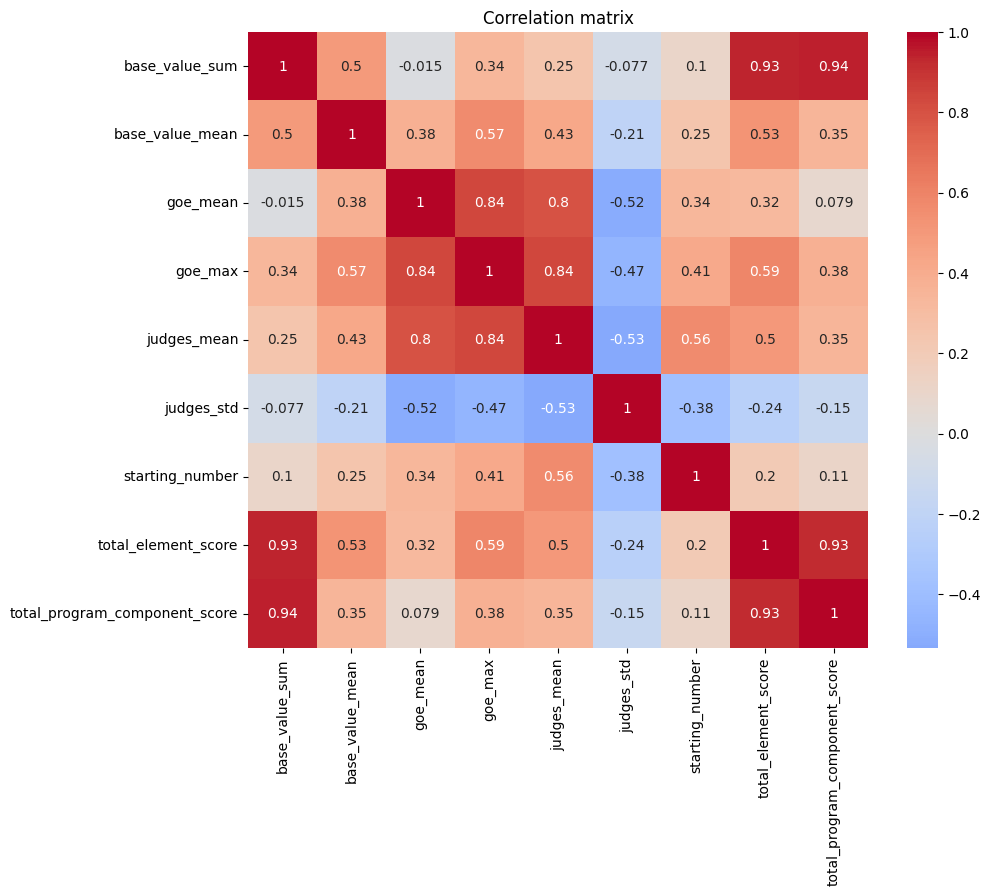

In [47]:
numeric_features = tech_features
plt.figure(figsize=(10, 8))
sns.heatmap(df[numeric_features + ['total_element_score', 'total_program_component_score']].corr(),
            annot=True, cmap='coolwarm', center=0)
plt.title('Correlation matrix')
plt.show()

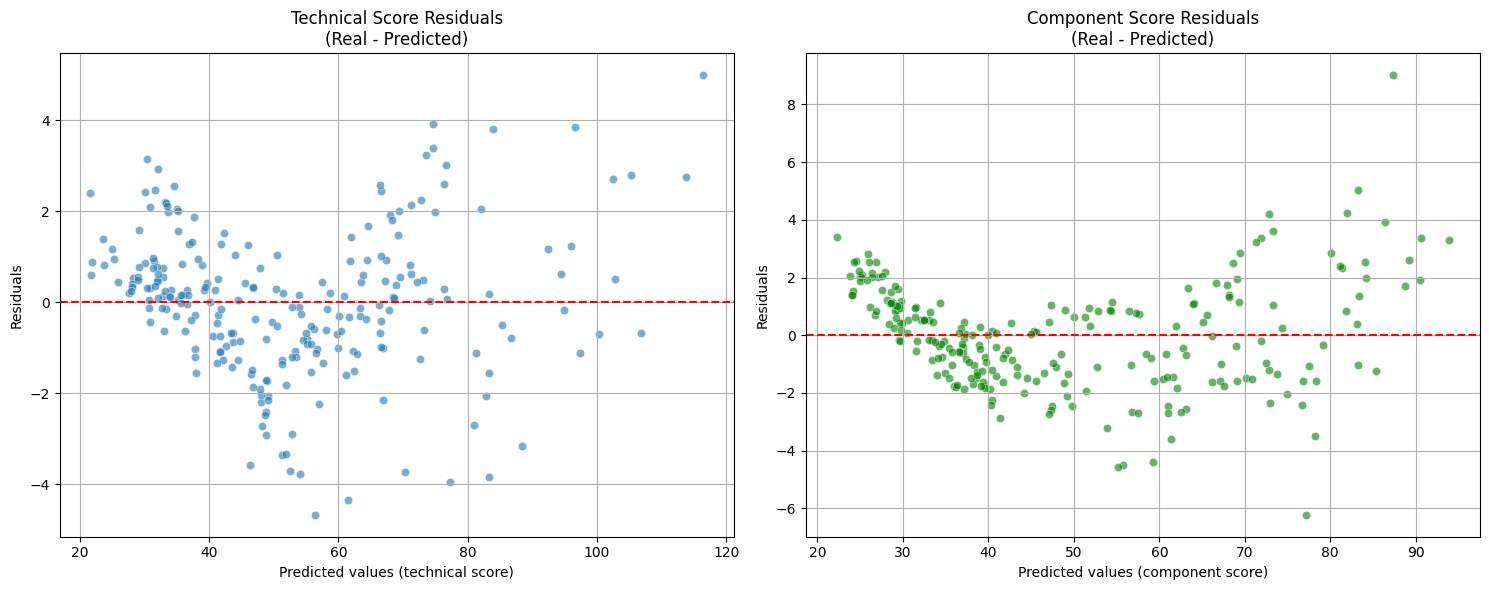

In [48]:
y_tech_pred = best_tech_model.predict(X)
y_comp_pred = best_comp_model.predict(X)

residuals_tech = y_tech - y_tech_pred
residuals_comp = y_comp - y_comp_pred

plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
sns.scatterplot(x=y_tech_pred, y=residuals_tech, alpha=0.6)
plt.axhline(0, color='r', linestyle='--')
plt.xlabel('Predicted values (technical score)')
plt.ylabel('Residuals')
plt.title('Technical Score Residuals\n(Real - Predicted)')
plt.grid(True)

plt.subplot(1, 2, 2)
sns.scatterplot(x=y_comp_pred, y=residuals_comp, alpha=0.6, color='green')
plt.axhline(0, color='r', linestyle='--')
plt.xlabel('Predicted values (component score)')
plt.ylabel('Residuals')
plt.title('Component Score Residuals\n(Real - Predicted)')
plt.grid(True)

plt.tight_layout()
plt.show()

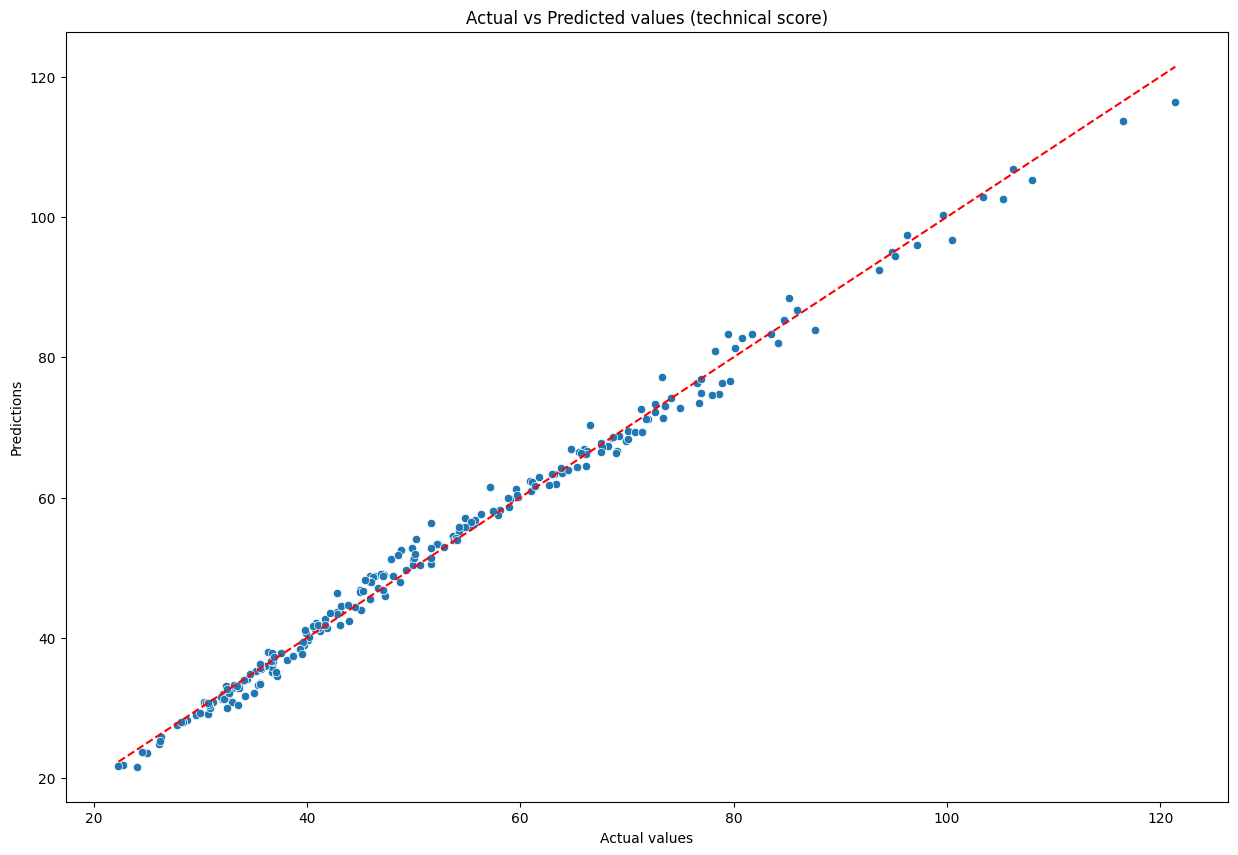

In [49]:
plt.figure(figsize=(15, 10))
sns.scatterplot(x=y_tech, y=y_tech_pred)
plt.plot([y_tech.min(), y_tech.max()], [y_tech.min(), y_tech.max()], 'r--')
plt.xlabel('Actual values')
plt.ylabel('Predictions')
plt.title('Actual vs Predicted values (technical score)')
plt.show()


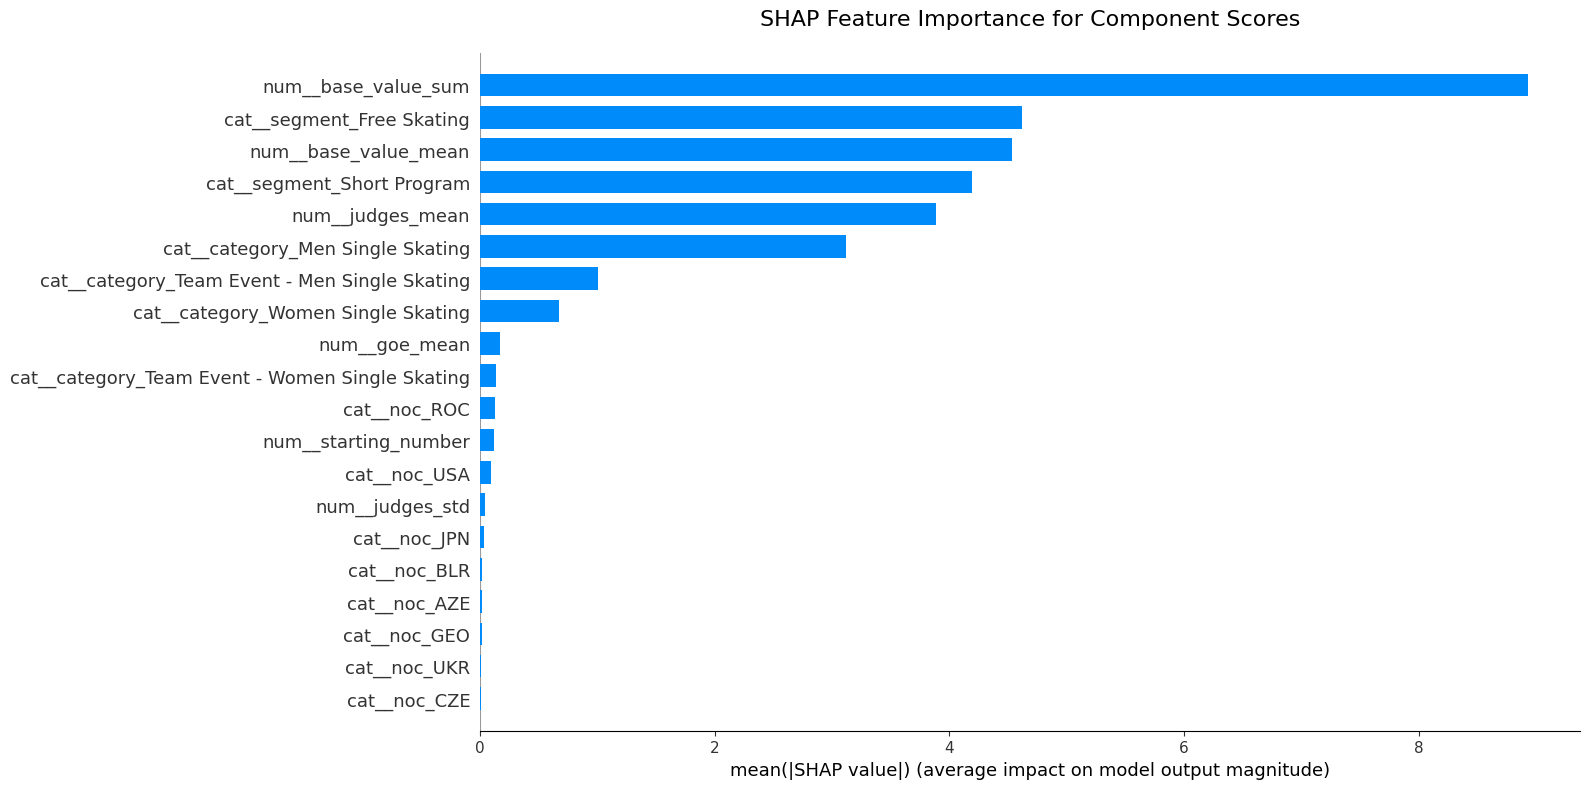

In [50]:
tech_features = ['base_value_sum', 'base_value_mean', 'goe_mean', 'goe_max',
                'judges_mean', 'judges_std', 'starting_number']
categorical_features = ['noc', 'category', 'segment']

X = df[tech_features + categorical_features]
y_tech = df['total_element_score']
y_comp = df['total_program_component_score']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), tech_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

model = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', Lasso(alpha=0.01))
])
model.fit(X, y_comp)

X_processed = model.named_steps['preprocessor'].transform(X)
feature_names = model.named_steps['preprocessor'].get_feature_names_out()

explainer = shap.LinearExplainer(model.named_steps['regressor'], X_processed)
shap_values = explainer.shap_values(X_processed)

plt.figure(figsize=(16, 8))
shap.summary_plot(
    shap_values,
    X_processed,
    feature_names=feature_names,
    plot_type='bar',
    show=False,
    plot_size=(16, 8)
)
plt.title("SHAP Feature Importance for Component Scores", fontsize=16, pad=20)
plt.tight_layout()
plt.show()

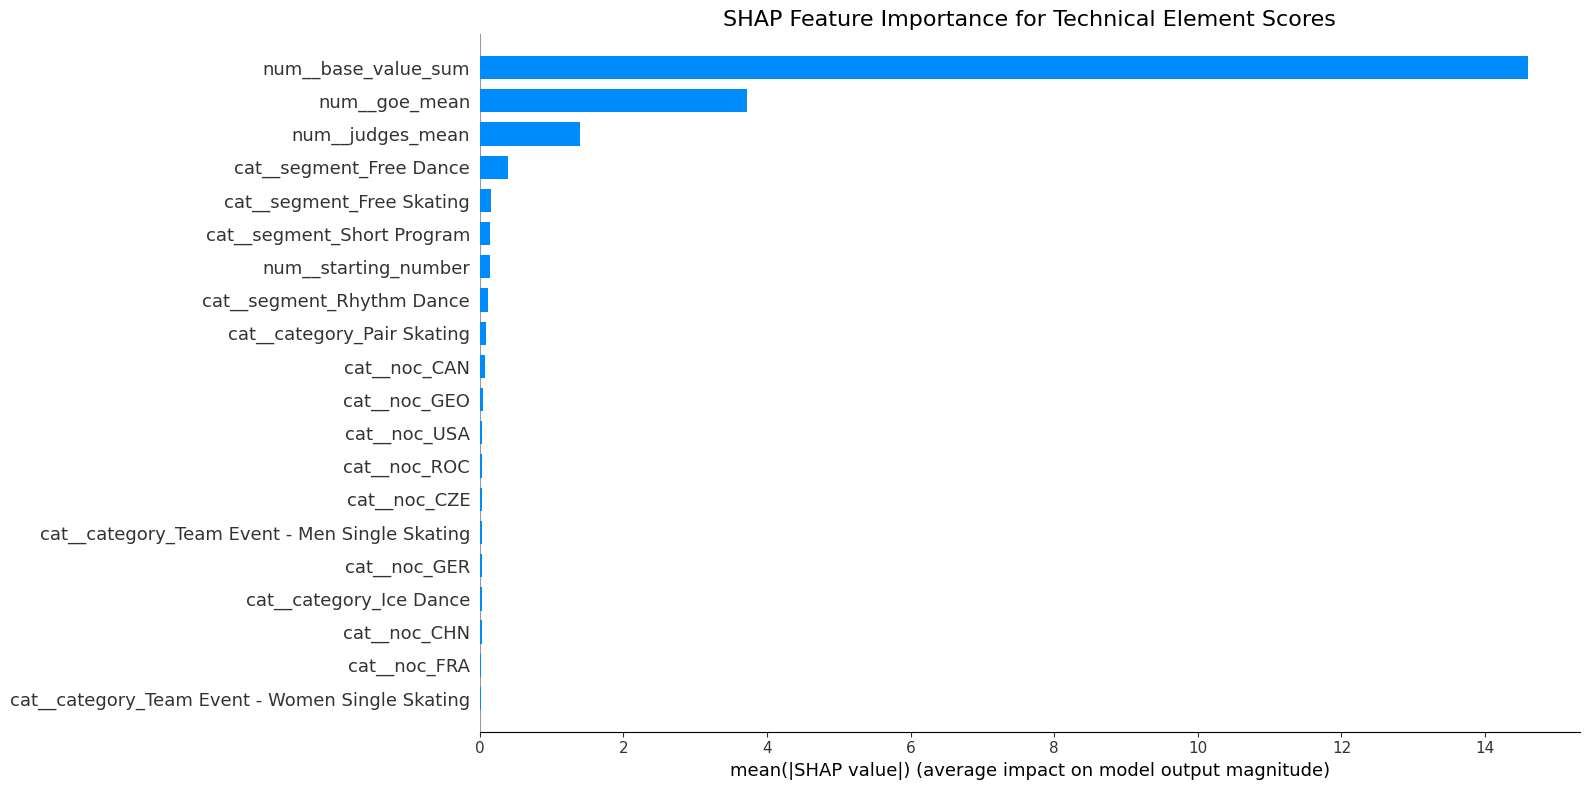

In [51]:
X = df[['starting_number', 'noc', 'category', 'segment',
        'base_value_sum', 'goe_mean', 'judges_mean']]
y_element = df['total_element_score']

X_train, X_test, ye_train, ye_test = train_test_split(
    X, y_element, test_size=0.2, random_state=42)

categorical_features = ['noc', 'category', 'segment']
numerical_features = ['starting_number', 'base_value_sum', 'goe_mean', 'judges_mean']

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),
        ('num', StandardScaler(), numerical_features)
    ])

pipeline_element = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', XGBRegressor(
        objective='reg:squarederror',
        n_estimators=100,
        max_depth=3,
        random_state=42))
])
pipeline_element.fit(X_train, ye_train)

X_train_processed = pipeline_element.named_steps['preprocessor'].transform(X_train)
feature_names = pipeline_element.named_steps['preprocessor'].get_feature_names_out()

explainer = shap.Explainer(pipeline_element.named_steps['regressor'])
shap_values = explainer(X_train_processed)

plt.figure(figsize=(16, 8))
shap.summary_plot(
    shap_values,
    X_train_processed,
    feature_names=feature_names,
    plot_type='bar',
    show=False,
    plot_size=(16, 8)
)
plt.title("SHAP Feature Importance for Technical Element Scores", fontsize=16)
plt.tight_layout()
plt.show()


In [55]:
df[['total_element_score', 'total_program_component_score', 'starting_number']] = \
    df[['total_element_score', 'total_program_component_score', 'starting_number']].astype(float)

X_stats = df[['total_element_score', 'noc', 'starting_number']].copy()

X_stats['noc'] = X_stats['noc'].astype('category').cat.codes

X_stats = sm.add_constant(X_stats)

try:
    model_component = sm.OLS(df['total_program_component_score'].astype(float),
                           X_stats.astype(float)).fit()

    print("\nHypothesis 1: Subjectivity in Component Scoring:")
    print(f"Coef: {model_component.params['total_element_score']:.4f}")
    print(f"P-value: {model_component.pvalues['total_element_score']:.4f}")
except Exception as e:
    print(f"Error: {str(e)}")



Hypothesis 1: Subjectivity in Component Scoring:
Coef: 0.8934
P-value: 0.0000


In [58]:
try:
    groups = [group['total_program_component_score'].values
              for name, group in df.groupby('noc')]

    print("\nHypothesis 2: Country Bias in Scoring:")
    h_stat, p_val = stats.kruskal(*groups)
    print(f"H = {h_stat:.2f}, P-value = {p_val:.4f}")
except Exception as e:
    print(f"Error: {str(e)}")



Hypothesis 2: Country Bias in Scoring:
H = 41.72, P-value = 0.0756


In [59]:
try:
    print("\nHypothesis 3: Influence of Starting Order on Judging:")
    corr, p_val = stats.spearmanr(df['starting_number'], df['total_segment_score'])
    print(f"Coef: {corr:.3f}, p-value: {p_val:.4f}")


except Exception as e:
    print(f"Error: {str(e)}")


Hypothesis 3: Influence of Starting Order on Judging:
Coef: 0.171, p-value: 0.0077
